In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#!/usr/bin/env python
#SBATCH --job-name=tc10
#SBATCH --partition=savio
#SBATCH --account=co_astro
#SBATCH --qos=astro_savio_normal
#SBATCH --time=24:00:00

this_sec = 10

from astropy.table import Table 
import numpy as np
import multiprocessing
from multiprocessing import Pool
import glob
import os
import subprocess
import eleanor
import time
import signal
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
import sys
sys.path.append(os.getcwd()) 

# read in the relevant table
table = Table.read('/global/scratch/kelbadry/ffi_targets_sector%d.fits' % this_sec)
Nstep = 10000
try:
    all_bad = glob.glob('/global/scratch/kelbadry/tess_ffi_sec%d/failed_list*' % this_sec)
    all_bad_idx = np.array([int(f.split('.npz')[0].split('_')[-1]) for f in all_bad])
    star_num = max(all_bad_idx)//Nstep
except:
    star_num = 0

# use this to prevent queries from running too long
def handler(signum, frame):
    print('timeout!!')
    raise ValueError("end of time")


# light curves we've already obtained
all_consolidated = glob.glob('/global/scratch/kelbadry/tess_ffi_sec%d/consolidated_lcs_*' % this_sec)
consolidated_tics = []
for consolidated in all_consolidated:
    tmp = np.load(consolidated)
    consolidated_tics.append(tmp['tic'])
    tmp.close()
if len(consolidated_tics):
    consolidated_tics = set(np.concatenate(consolidated_tics))
else: 
    consolidated_tics = set()

# add ones we've obtained but not consolidated yet
files_disk = glob.glob('/global/scratch/kelbadry/tess_ffi_sec%d/lcs_*' % this_sec)
tics_disk = np.array([ff.split('.npz')[0].split('_')[-1] for ff in files_disk]).astype(int)
consolidated_tics = set(np.concatenate([tics_disk, list(consolidated_tics)]))

# resubmit job when this one finishes
if (star_num + 1) * Nstep < len(table):
    os.system('sbatch --dependency=afterany:%s submit_tess_sec%d_ffi.py' % (os.environ['SLURM_JOB_ID'], this_sec))

# move to the TESS directory to try to prevent downloading a bunch of tesscut files here randomly
os.chdir('/global/scratch/kelbadry/.eleanor/tesscut')
print(os.getcwd() )


# loop through in batches of 10000
for i in range(star_num, len(table)//Nstep):
    m = (np.arange(len(table)) > Nstep*i) & (np.arange(len(table)) < Nstep*(i+1) )
    these_ids =  np.array([int(x) for x in table['ID'].data[m]])
    these_ras =  table['ra'].data[m]
    these_decs = table['dec'].data[m]
    print('starting %d...' % i)
    have = np.in1d(these_ids, np.array(list(consolidated_tics)))
    these_ids, these_ras, these_decs = these_ids[~have], these_ras[~have], these_decs[~have]
    print('found %d files still needed' % len(these_ids))

    def process_single_number(k):
        if k % 1000 == 0: 
            kill_stale_jobs_savio()
        print('dealing with TIC %d' % these_ids[k])
        maxsector = 16
        result = tess_stars2px(8675309, these_ras[k], these_decs[k])
        sectors_appear = result[3][result[3] < maxsector + 0.5]
        if this_sec not in sectors_appear:
            print('skipping, outside sector footprint: %d' % these_ids[k])
            return k, 'no_sector'

        path = '/global/scratch/kelbadry/tess_ffi_sec%d/lcs_' % this_sec + str(these_ids[k])+'.npz'
        if os.path.exists(path): # shouldn't happen anymore since we checked files disk 
            print('done already')
            return
 
        #if these_ids[k] in consolidated_tics: return
        try:
            signal.signal(signal.SIGALRM, handler)
            signal.alarm(240) # four minutes
            s = [this_sec]
            ts, lcs, lc_errs, sectors = [], [], [], []
            lcs_raw, lcs_psf = [], []
            for sec in s:
                time.sleep(np.random.randint(0, 10))
            
                # keep trying repeatedly
                found_star, count = False, 0
                while not found_star and count < 15:
                    try:
                        star = eleanor.Source(tic = these_ids[k], sector=int(sec), tc = True)
                        full_path = '/global/scratch/kelbadry/.eleanor/tesscut/'+star.postcard

                        # check whether tesscut returned nonsense. This seems to happen sometimes as a consequence of
                        # many jobs running in parallel
                        if np.sum(np.diff(star.cutout[1].data['TIME']) < 0):
                            print('Tesscut messed up the time... try again. %d' % these_ids[k])
                            os.remove(full_path)
                            raise ValueError('bad tesscut!')

                        data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf = True)

                        # redo with an aperture that won't avoid variable stars
                        eleanor.TargetData.custom_aperture(data, shape='circle', r=1.5, method='exact')
                        eleanor.TargetData.get_lightcurve(data)
                        q = data.quality == 0
                        t, lc = data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q])
                        lc_err = data.flux_err[q]/np.median(data.corr_flux[q])
                        lc_raw, lc_psf = data.raw_flux[q], data.psf_flux[q]/np.median(data.psf_flux[q])
                        os.remove(full_path)
                        assert(np.sum(np.diff(t) < 0) == 0)
                        assert(np.nanmedian(lc_err) < 1)
                        
                        found_star = True
                    except:
                        count += 1
                        time.sleep(2.2)
                if count >= 15 and not found_star:
                    print('could not find %d this sector, or there was some other issue' % these_ids[k])
                    continue

                ts.append(t)
                lcs.append(lc)
                lc_errs.append(lc_err)
                sectors.append(sec)
                lcs_raw.append(lc_raw)
                lcs_psf.append(lc_psf)
            signal.alarm(0)
            if not len(ts):
                raise ValueError('failed to get any light curves!')
        except: 
            return k, 'failed'
        np.savez(path, t = ts, lc = lcs, lc_err = lc_errs, sectors = sectors, lc_raw =lcs_raw, lc_psf= lcs_psf)
    
    these_nums = list(np.arange(len(these_ids)))
    with MultiPool() as pool:
        all_result = list(pool.map(process_single_number, these_nums))
    
    failed, no_sectors = [], []
    for x in all_result:
        if x is None:
            continue 
        else:
            if x[1] == 'failed':
                failed.append(x[0])
            elif x[1] == 'no_sector':
                no_sectors.append(x[0])
            else:
                raise ValueError('unknown result!')
    if len(failed):
        failed_ids = these_ids[np.array(failed)]
    else: failed_ids = []
    if len(no_sectors):
        no_sector_ids = these_ids[np.array(no_sectors)]
    else: no_sector_ids = []

    # note which ones failed 
    path = '/global/scratch/kelbadry/tess_ffi_sec%d/failed_list_%d' % (this_sec, (i+1)*Nstep)+'.npz'
    np.savez(path, failed_ids = failed_ids, no_sector_ids = no_sector_ids)



In [9]:
import warnings

In [10]:
warnings.simplefilter("ignore")

(array([251., 128.,  56.,  37.,  36.,  37.,  29.,  25.,  25.,   5.]),
 array([6000.200195 , 6389.9801755, 6779.760156 , 7169.5401365,
        7559.320117 , 7949.1000975, 8338.880078 , 8728.6600585,
        9118.440039 , 9508.2200195, 9898.       ]),
 <a list of 10 Patch objects>)

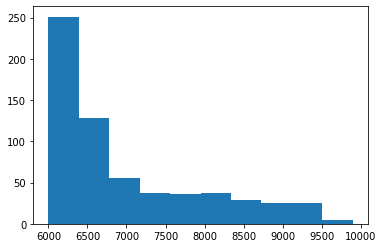

In [11]:
df = pd.read_csv('../data/tess_toi.csv', skiprows=4)
plt.hist(df['Stellar Teff (K)'])

In [27]:
#df.iloc[df['Period (days)'].argmax()]

In [63]:
import eleanor
import lightkurve as lk

In [59]:
star = eleanor.multi_sectors(tic=309402106, sectors='all', tc=True)

time, flux_corr, flux_psf, flux_err = [], [], []
for s in star:
    data = eleanor.TargetData(s, height=15, width=15, bkg_size=31, do_psf = True)

    # redo with an aperture that won't avoid variable stars
    eleanor.TargetData.custom_aperture(data, shape='circle', r=1.5, method='exact')
    eleanor.TargetData.get_lightcurve(data)
    
    q = data.quality == 0
    time.extend(data.time[q])
    flux_corr.extend(data.corr_flux[q]/np.median(data.corr_flux[q]))
    flux_psf.extend(data.psf_flux[q]/np.median(data.psf_flux[q]))
    flux_err.extend(data.flux_err[q]/np.median(data.corr_flux[q]))

np.savetxt()
# q = data.quality == 0
# t, lc = data.time[q], data.corr_flux[q]/np.median(data.corr_flux[q])
# lc_err = data.flux_err[q]/np.median(data.corr_flux[q])
# lc_raw, lc_psf = data.raw_flux[q], data.psf_flux[q]/np.median(data.psf_flux[q])

Found star in Sector(s) 1 5 8 9 10 11


100%|██████████| 1248/1248 [00:12<00:00, 101.69it/s]


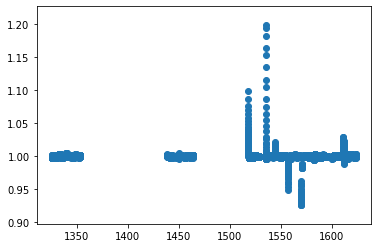

In [62]:
plt.scatter(time, flux)

In [56]:
aa = eleanor.TargetData.custom_aperture(data, shape='circle', r=1.5, method='exact')

In [58]:
type(aa)

NoneType

In [28]:
star = eleanor.multi_sectors(tic=309402106, sectors='all')

Found star in Sector(s) 1 5 8 9 10 11
Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  1...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  1 now available.
Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  5...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  5 now available.
Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  8...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target A

In [29]:
star

In [30]:

data = []
for s in star:
    data.append(eleanor.TargetData(s, height=15, width=15, bkg_size=31, 
                                   do_psf=True, do_pca=True))




100%|██████████| 968/968 [00:08<00:00, 111.59it/s]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


100%|██████████| 1154/1154 [00:10<00:00, 105.33it/s]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


100%|██████████| 1211/1211 [00:10<00:00, 115.33it/s]


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


100%|██████████| 1248/1248 [00:12<00:00, 103.67it/s]


(0.5, 1.1)

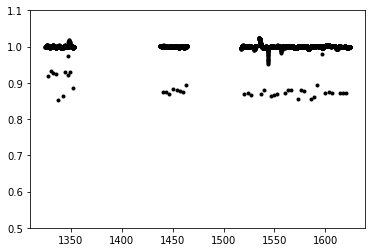

In [46]:
for d in data:
    plt.plot(d.time, d.psf_flux / np.median(d.psf_flux), '.k')
plt.ylim(0.5, 1.1)

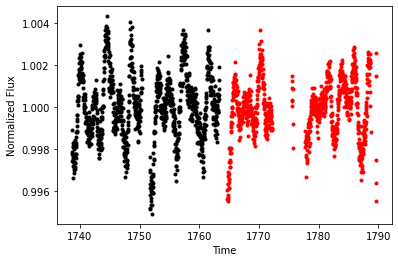

(1740.0, 1790.0)

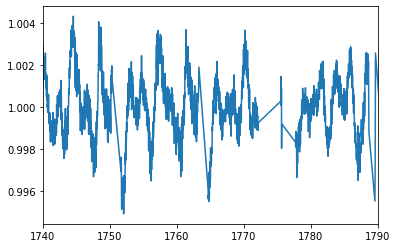

In [59]:

plt.plot(data[0].time[q0], data[0].corr_flux[q0]/np.median(data[0].corr_flux[q0]), 'k.')
plt.plot(data[1].time[q1], data[1].corr_flux[q1]/np.median(data[1].corr_flux[q1]), 'r.')

plt.ylabel('Normalized Flux')
plt.xlabel('Time')

plt.show()

plt.plot(time, flux)
plt.xlim(1740, 1790)

In [33]:
lc = data[0].to_lightkurve(flux=data[0].psf_flux)
for d in data[1:]:
    print(d)
    lc.append(d.to_lightkurve(flux=d.psf_flux))

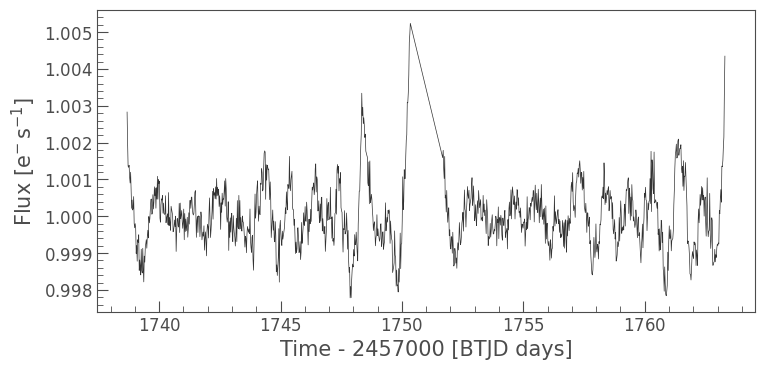

In [34]:
lc.flatten().plot()

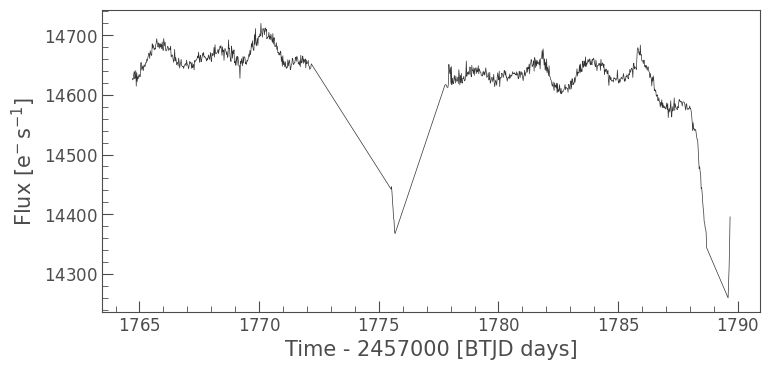

In [35]:
lc = data[1].to_lightkurve(flux=data[1].psf_flux)
lc.plot()

In [57]:
time, flux, flux_err = [], [], []
for d in data:
    quality_flags = d.quality == 0
    time.extend(d.time[quality_flags])
    flux.extend(d.corr_flux[quality_flags]/np.median(d.corr_flux[quality_flags]))

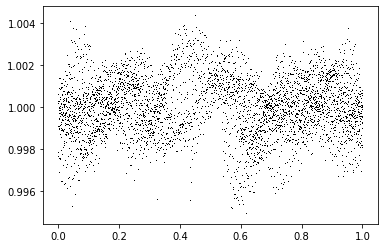

In [58]:
plt.plot(np.array(time) % 6.45054 / 6.45054, flux,',k')

# K2

In [58]:
df = pd.read_csv('../data/epic_query.tsv', skiprows=124, delimiter='\t', 
                names=['ID','RAJ2000','DEJ2000','HIP','TYC','UCAC4','2MASS','SDSS','OType','Kpflag','Sflag','pmRA','e_pmRA','pmDEC',
                        'e_pmDEC','plx','e_plx','Bmag','e_Bmag','Vmag','e_Vmag','umag','e_umag','gmag','e_gmag','rmag','e_rmag',
                        'imag','e_imag','zmag','e_zmag','Jmag','e_Jmag','Hmag','e_Hmag','Ksmag','e_Ksmag','Kpmag','Teff','E_Teff','e_Teff','logg','E_logg',
                        'e_logg','[Fe/H]'',E_[Fe/H]','e_[Fe/H]','Rad','E_Rad','e_Rad','Mass','E_Mass','e_Mass','rho','E_rho','e_rho','Dist',
                        'E_Dist','e_Dist','E(B-V)','E_E(B-V)','e_E(B-V)','NOMAD1','f_2MASS','Prox','Kflag', '??'],
#                 dtype={'ID': int}
                 index_col=None
                )
k2_toi = pd.read_csv('../data/K2_TOI.csv', skiprows=10)
# k2_toi = k2_toi.merge(df, left_on='EPIC ID', right_on='ID')
# k2_toi.to_csv('../data/k2_toi.csv')

In [ ]:
wget_commands = []
for kid in koi[~koi.kepid.isin(kics)]['kepid'].values:
    kicid = str(kid).zfill(9)
    wget = "wget -nH --cut-dirs=6 -r -l0 -c -q -N -np -R 'index*' -erobots=off -A 'kplr*_lc_*.tar' https://archive.stsci.edu/pub/kepler/lightcurves//" + kicid[:4] + '/' + kicid + '/'
    wget_commands.append(wget)
    
np.savetxt('kic_dsct.txt', wget_commands, delimiter=" ", fmt="%s")

In [ ]:
import glob
import tqdm
import shutil
import lightkurve as lk
import tarfile
from multiprocessing import Pool

files = glob.glob('data/Kepler/*.tar')#[:10]

def stitcher(file):
    tar = tarfile.open(file)
    tar.extractall('data/Kepler/extracted/')
    tar.close()

    kplr = file.split('/')[-1].split('_')[0]
    folder = kplr.lstrip('kplr')
    lc_files = glob.glob('data/Kepler/extracted/' + folder + '/kplr*.fits')
    
    lc = lk.KeplerLightCurveFile(lc_files[0]).PDCSAP_FLUX.normalize()
    for lc_file in lc_files[1:]:
        lc = lc.append(lk.KeplerLightCurveFile(lc_file).PDCSAP_FLUX.normalize())

    lc = lc.remove_nans()
    time = lc.time
    flux = lc.flux
    sort = np.argsort(time)
    np.savetxt('data/Kepler/lc/' + kplr + '.txt', list(zip(time[sort], flux[sort])))
    
with Pool(4) as p:
    r = list(tqdm.tqdm(p.imap(stitcher, files), total=len(files)))

In [ ]:
from multiprocessing import Pool

def searcher(file):
    time, flux = np.loadtxt(file, usecols=(0,1)).T
    lc = lk.LightCurve(time, flux).remove_outliers()
    fig, ax = plt.subplots(2,1, figsize=[10,10])
    lc.plot(ax=ax[0])
    lc.to_periodogram().plot(ax=ax[1])
    fname = file.split('.')[0].split('/')[-1]
    plt.savefig('dScts/Kepler/' + fname + '.png', dpi=300, bbox_inches='tight')
    plt.clf()
    plt.close(fig)
    
with Pool(4) as p:
    r = list(tqdm.tqdm(p.imap(searcher, files), total=len(files)))